In [77]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import robust_scale, scale
from sklearn.preprocessing import StandardScaler, RobustScaler, robust_scale, scale
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

from ssri_interactions.io import load_derived_generic, load_neurons
from ssri_interactions.plots import heatmap
from ssri_interactions.config import Config, ExperimentInfo

import seaborn as sns
import joblib

In [78]:
# load data

df_spiketrains = load_derived_generic("spiketrain_stats_segments.csv")
df_wavemap = load_derived_generic("wavemap.csv")
df_waveforms = load_derived_generic("waveform_summary.csv")
neurons = load_neurons()
estimator = joblib.load(Config.data_dir.parent / "models" / "kmeans_pipeline.joblib")



In [79]:
# preprocess 

df = pd.merge(df_waveforms, df_spiketrains, on="neuron_id", how="outer")
df = pd.merge(df, df_wavemap, on="neuron_id", how="outer")


df["mean_firing_rate"] = np.select(
    condlist=[
        df["mean_firing_rate"] <= 0.5,
        df["mean_firing_rate"] >= 25,
    ], choicelist=[np.nan,np.nan],
    default=df["mean_firing_rate"]
)
df_cluster = df.copy()
cols = ["cv_isi_burst", "mean_firing_rate", "width_basepost"]
df_cluster = df_cluster
X = df_cluster[cols].values
df["neuron_type"] = estimator.predict(X)

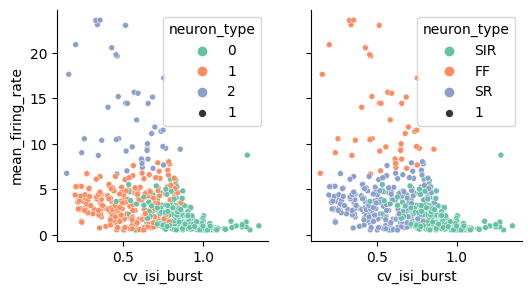

In [80]:
# apply previous clustering pipeline, plot to confirm neuron types

f = plt.figure(figsize=(6, 3))

ax1, ax2 = f.subplots(1, 2, sharey=True, sharex=True)

sns.scatterplot(
    data=df,
    y="mean_firing_rate",
    x="cv_isi_burst",
    hue="neuron_type",
    palette="Set2",
    ax=ax1,
    size=1
)

mapper = {0:"SIR", 1:"SR", 2:"FF"}
df["neuron_type"] = df["neuron_type"].map(mapper)

sns.scatterplot(
    data=df,
    y="mean_firing_rate",
    x="cv_isi_burst",
    hue="neuron_type",
    palette="Set2",
    ax=ax2,
    size=1
)


sns.despine(fig=f)

In [81]:
sessions = neurons["session_name"].values
neurons["group"] = np.select(
    [
        np.isin(sessions, ExperimentInfo.sal_sessions),
        np.isin(sessions, ExperimentInfo.cit_sessions),
        np.isin(sessions, ExperimentInfo.discontunation_sessions),
    ],
    ["SAL", "CIT", "DIS"], 
    default=np.nan
    )


neurons_cols = ["neuron_id", "session_name", "group_name", "experiment_name", "group"]
stats_cols = ["neuron_id", "neuron_type", "width_basepost", "mean_firing_rate", "cv_isi_burst"]

neuron_types = pd.merge(
    left=neurons[neurons_cols],
    right=df[stats_cols],
    on="neuron_id",
    how="outer"
)

neuron_types.to_csv(Config.derived_data_dir / "neuron_types.csv", index=False)